In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.generate_samples as generate_samples
import model.image_unet as image_unet
import model.train_model as train_model
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [3]:
class VariancePreservingSDE:
    
    def __init__(self, beta_0, beta_1, input_shape, seed=None):
        """
        Arguments:
            `beta_0`: beta(0); see below
            `beta_1`: beta(1); beta(t) will be linearly interpolated
                between beta(0) and beta(1)
            `input_shape`: a tuple of ints which is the shape of input
                tensors x; does not include batch dimension
            `seed`: random seed for sampling and running the SDE
        """
        self.input_shape = input_shape
        self.rng = torch.Generator(device=DEVICE)
        if seed:
            self.rng.manual_seed(seed)
        
        self.beta_0 = torch.tensor(beta_0).to(DEVICE)
        self.delta_beta = torch.tensor(beta_1 - beta_0).to(DEVICE)
        self.string = "Variance Preserving SDE (beta(t) = %.2f + %.2ft)" % (beta_0, beta_1 - beta_0)
        
        
    def _inflate_dims(self, v):
        """
        Given a tensor vector `v`, appends dimensions of size 1 so that
        it has the same number of dimensions as `self.input_shape`. For
        example, if `self.input_shape` is (3, 50, 50), then this function
        turns `v` from a B-tensor to a B x 1 x 1 x 1 tensor. This is
        useful for combining the tensor with things shaped like the input
        later.
        Arguments:
            `v`: a B-tensor
        Returns a B x `self.input_shape` tensor.
        """
        return v[(slice(None),) + ((None,) * len(self.input_shape))]
        
    
    def _beta(self, t):
        """
        Computes beta(t).
        Arguments:
            `t`: a B-tensor of times
        Returns a B-tensor of beta values.
        """
        return self.beta_0 + (self.delta_beta * t)
        
        
    def _beta_bar(self, t):
        """
        Computes the integral of beta(0) to beta(t).
        Arguments:
            `t`: a B-tensor of times
        Returns a B-tensor of beta-bar values.
        """
        return (self.beta_0 * t) + (0.5 * self.delta_beta * torch.square(t))
        
    
    def drift_coef_func(self, xt, t):
        """
        Definition of drift coefficient f(xt, t).
        Arguments:
            `xt`: a B x `self.input_shape` tensor containing the data at
                some time points
            `t`: a B-tensor containing the time in the SDE for each input
        Returns a B x `self.input_shape` tensor.
        """
        return -0.5 * self._inflate_dims(self._beta(t)) * xt
    
    
    def diff_coef_func(self, xt, t):
        """
        Definition of diffusion coefficient g(t).
        Arguments:
            `xt`: a B x `self.input_shape` tensor containing the data at
                some time points
            `t`: a B-tensor containing the time in the SDE
        Returns a B x `self.input_shape` tensor.
        """
        return self._inflate_dims(torch.sqrt(self._beta(t)))
    
    
    def forward(self, x0, t, return_score=True):
        """
        Runs the SDE forward given starting point `x0` and a time `t`.
        Optional returns the score: the gradient (with respect to x) of the
        log conditional probability, pt(xt | x0).
        Arguments:
            `xt`: a B x `self.input_shape` tensor containing the data at
                some time points
            `t`: a B-tensor containing the time in the SDE for each input
        Returns a B x `self.input_shape` tensor to represent xt. If
        `return_score` is True, then also returns a B x `self.input_shape`
        tensor which is the gradient of the log conditional probability
        (with respect to `xt`).
        """
        z = torch.normal(
            torch.zeros_like(x0), torch.ones_like(x0), generator=self.rng
        )  # Shape: B x ...
        
        mean = x0 * torch.exp(-0.5 * self._inflate_dims(self._beta_bar(t)))
        variance = 1 - torch.exp(-self._beta_bar(t))
        std = self._inflate_dims(torch.sqrt(variance))  # Shape: B x ...
        
        xt = mean + (std * z)
        
        if return_score:
            score = -z / std
            return xt, score
        else:
            return xt
        

    def mean_score_mag(self, t):
        """
        Returns the average magnitude (squared L2 norm) of the score
        (averaged over sampling and data distribution), divided by the
        size of `x`. That is, this should be ||score||_2^2 / d, where d
        is the size of `x`.
        Arguments:
            `t`: a B-tensor containing the time in the SDE
        Returns a B-tensor containing the expected magnitude of the score
        function at each time `t`.
        """
        variance = 1 - torch.exp(-self._beta_bar(t))
        return 1 / variance  # Shape: B
        
        
    def sample_prior(self, num_samples, t):
        """
        Samples from the prior distribution specified by the SDE at time `t`.
        Arguments:
            `num_samples`: B, the number of samples to return
            `t`: a B-tensor containing the times in the SDE to sample for
        Returns a B x `self.input_shape` tensor for the `xt` values that
        are sampled.
        """
        # We will sample in the limit as t approaches infinity
        shape = torch.Size([num_samples]) + torch.Size(self.input_shape)
        return torch.normal(
            torch.zeros(shape).to(DEVICE), torch.ones(shape).to(DEVICE), generator=self.rng
        )  # Shape: B x ...
    
    
    def __str__(self):
        return self.string

### Define the score model $s_{\theta}$

We will start by defining it for image data, using a U-net architecture.

In [4]:
class MultitaskScoreUNetTimeConcat(torch.nn.Module):

    def __init__(
        self, num_tasks, t_limit=1,
        enc_dims=[32, 64, 128, 256], dec_dims=[32, 64, 128],
        time_embed_size=32,
        mean_score_mag=None, data_channels=1
    ):
        """
        Initialize a time-dependent score-based U-net.
        Arguments:
            `num_tasks`: number of tasks to output, T
            `t_limit`: maximum time horizon
            `enc_dims`: the number of channels in each encoding layer
            `dec_dims`: the number of channels in each decoding layer
            `time_embed_size`: size of the time embeddings
            `mean_score_mag`: if given, rescales the model outputs by multiplying
                by the average score magnitude (L2 norm); this must be a function
                which takes in a B-tensor of time points, and returns a B-tensor
                of expected squared L2 norms
            `data_channels`: number of channels in input image
        Note this architecture assumes the initial depth of the images is 1.
        """
        super().__init__()
        
        self.num_tasks = num_tasks
        self.t_limit = t_limit
        self.mean_score_mag = mean_score_mag
        
        # Encoders: receptive field increases and depth increases
        self.conv_e1_tasks = torch.nn.ModuleList()
        self.time_dense_e1_tasks = torch.nn.ModuleList()
        self.norm_e1_tasks = torch.nn.ModuleList()
        self.conv_e2_tasks = torch.nn.ModuleList()
        self.time_dense_e2_tasks = torch.nn.ModuleList()
        self.norm_e2_tasks = torch.nn.ModuleList()
        self.conv_e3_tasks = torch.nn.ModuleList()
        self.time_dense_e3_tasks = torch.nn.ModuleList()
        self.norm_e3_tasks = torch.nn.ModuleList()
        self.conv_e4_tasks = torch.nn.ModuleList()
        self.time_dense_e4_tasks = torch.nn.ModuleList()
        self.norm_e4_tasks = torch.nn.ModuleList()
        for _ in range(1):
            self.conv_e1_tasks.append(
                torch.nn.Conv2d(
                    data_channels + time_embed_size, enc_dims[0], kernel_size=3, stride=1, bias=False
                )
            )
            self.time_dense_e1_tasks.append(torch.nn.Linear(2, time_embed_size))
            self.norm_e1_tasks.append(torch.nn.GroupNorm(4, num_channels=enc_dims[0]))
            self.conv_e2_tasks.append(
                torch.nn.Conv2d(
                    enc_dims[0] + time_embed_size, enc_dims[1], kernel_size=3, stride=2, bias=False
                )
            )
            self.time_dense_e2_tasks.append(torch.nn.Linear(2, time_embed_size))
            self.norm_e2_tasks.append(torch.nn.GroupNorm(32, num_channels=enc_dims[1]))
            self.conv_e3_tasks.append(
                torch.nn.Conv2d(
                    enc_dims[1] + time_embed_size, enc_dims[2], kernel_size=3, stride=2, bias=False
                )
            )
            self.time_dense_e3_tasks.append(torch.nn.Linear(2, time_embed_size))
            self.norm_e3_tasks.append(torch.nn.GroupNorm(32, num_channels=enc_dims[2]))
            self.conv_e4_tasks.append(
                torch.nn.Conv2d(
                    enc_dims[2] + time_embed_size, enc_dims[3], kernel_size=3, stride=2, bias=False
                )
            )
            self.time_dense_e4_tasks.append(torch.nn.Linear(2, time_embed_size))
            self.norm_e4_tasks.append(torch.nn.GroupNorm(32, num_channels=enc_dims[3]))

        # Decoders: depth decreases        
        self.conv_d4_tasks = torch.nn.ModuleList()
        self.time_dense_d4_tasks = torch.nn.ModuleList()
        self.norm_d4_tasks = torch.nn.ModuleList()
        self.conv_d3_tasks = torch.nn.ModuleList()
        self.time_dense_d3_tasks = torch.nn.ModuleList()
        self.norm_d3_tasks = torch.nn.ModuleList()
        self.conv_d2_tasks = torch.nn.ModuleList()
        self.time_dense_d2_tasks = torch.nn.ModuleList()
        self.norm_d2_tasks = torch.nn.ModuleList()
        self.conv_d1_tasks = torch.nn.ModuleList()
        for _ in range(num_tasks):
            self.conv_d4_tasks.append(
                torch.nn.ConvTranspose2d(
                    enc_dims[3] + time_embed_size, dec_dims[2], 3, stride=2, bias=False
                )
            )
            self.time_dense_d4_tasks.append(torch.nn.Linear(2, time_embed_size))
            self.norm_d4_tasks.append(
                torch.nn.GroupNorm(32, num_channels=dec_dims[2])
            )
            self.conv_d3_tasks.append(
                torch.nn.ConvTranspose2d(
                    dec_dims[2] + enc_dims[2] + time_embed_size, dec_dims[1], 3, stride=2, output_padding=1, bias=False
                )
            )
            self.time_dense_d3_tasks.append(torch.nn.Linear(2, time_embed_size))
            self.norm_d3_tasks.append(
                torch.nn.GroupNorm(32, num_channels=dec_dims[1])
            )
            self.conv_d2_tasks.append(
                torch.nn.ConvTranspose2d(
                    dec_dims[1] + enc_dims[1] + time_embed_size, dec_dims[0], 3, stride=2, output_padding=1, bias=False
                )
            )
            self.time_dense_d2_tasks.append(torch.nn.Linear(2, time_embed_size))
            self.norm_d2_tasks.append(
                torch.nn.GroupNorm(32, num_channels=dec_dims[0])
            )
            self.conv_d1_tasks.append(
                torch.nn.ConvTranspose2d(
                    dec_dims[0] + enc_dims[0], data_channels, 3, stride=1, bias=True
                )
            )

        # Activation functions
        self.swish = lambda x: x * torch.sigmoid(x)  # Swish activation: x * sigmoid(x)

    def forward(self, xt, t):
        """
        Forward pass of the network.
        Arguments:
            `xt`: B x 1 x H x W tensor containing the images to train on
            `t`: B-tensor containing the times to train the network for each
                image
        Returns a B x T x 1 x H x W tensor which consists of the (unnormalized)
        score estimate.
        """
        # Get the time embeddings for `t`
        # We first sample vector z from some zero-mean Gaussian (of fixed variance),
        # and then we embed the time as cos(2 * pi * t * z) and sin(2 * pi * t * z)
        time_embed_args = t[:, None] * 2 * np.pi / t_limit  # Shape: B x 1
#         time_embed = self.swish(
#             self.time_embed_dense(
#                 torch.cat([torch.sin(time_embed_args), torch.cos(time_embed_args)], dim=1)
#             )
#         )
        time_embed = self.swish(
            torch.cat([torch.sin(time_embed_args), torch.cos(time_embed_args)], dim=1)
        )
        # Shape: B x 2
        
        # Encoding
        enc_1_outs = [
            self.swish(self.norm_e1_tasks[i](self.conv_e1_tasks[i](
                torch.cat([
                    xt,
                    torch.tile(self.time_dense_e1_tasks[i](time_embed)[:, :, None, None], (1, 1) + xt.shape[2:])
                ], dim=1)
            ))) for i in [0] * self.num_tasks
        ]
        enc_2_outs = [
            self.swish(self.norm_e2_tasks[i](self.conv_e2_tasks[i](
                torch.cat([
                    enc_1_outs[i],
                    torch.tile(self.time_dense_e2_tasks[i](time_embed)[:, :, None, None], (1, 1) + enc_1_outs[i].shape[2:])
                ], dim=1)
            ))) for i in [0] * self.num_tasks
        ]
        enc_3_outs = [
            self.swish(self.norm_e3_tasks[i](self.conv_e3_tasks[i](
                torch.cat([
                    enc_2_outs[i],
                    torch.tile(self.time_dense_e3_tasks[i](time_embed)[:, :, None, None], (1, 1) + enc_2_outs[i].shape[2:])
                ], dim=1)
            ))) for i in [0] * self.num_tasks
        ]
        enc_4_outs = [
            self.swish(self.norm_e4_tasks[i](self.conv_e4_tasks[i](
                torch.cat([
                    enc_3_outs[i],
                    torch.tile(self.time_dense_e4_tasks[i](time_embed)[:, :, None, None], (1, 1) + enc_3_outs[i].shape[2:])
                ], dim=1)
            ))) for i in [0] * self.num_tasks
        ]
        
        # Decoding
        dec_4_outs = [
            self.swish(self.norm_d4_tasks[i](self.conv_d4_tasks[i](
                torch.cat([
                    enc_4_outs[i],
                    torch.tile(self.time_dense_d4_tasks[i](time_embed)[:, :, None, None], (1, 1) + enc_4_outs[i].shape[2:])
                ], dim=1)
            ))) for i in range(self.num_tasks)
        ]
        dec_3_outs = [
            self.swish(self.norm_d3_tasks[i](self.conv_d3_tasks[i](
                torch.cat([
                    dec_4_outs[i], enc_3_outs[i],
                    torch.tile(self.time_dense_d3_tasks[i](time_embed)[:, :, None, None], (1, 1) + dec_4_outs[i].shape[2:])
                ], dim=1)
            ))) for i in range(self.num_tasks)
        ]
        dec_2_outs = [
            self.swish(self.norm_d2_tasks[i](self.conv_d2_tasks[i](
                torch.cat([
                    dec_3_outs[i], enc_2_outs[i],
                    torch.tile(self.time_dense_d2_tasks[i](time_embed)[:, :, None, None], (1, 1) + dec_3_outs[i].shape[2:])
                ], dim=1)
            ))) for i in range(self.num_tasks)
        ]
        dec_1_out = [
            self.conv_d1_tasks[i](torch.cat([dec_2_outs[i], enc_1_outs[i]], dim=1))
            for i in range(self.num_tasks)
        ]
        dec_1_out = torch.stack(dec_1_out, dim=1)  # Shape: B x T x 1 x H x W
        
        if self.mean_score_mag:
            pred = dec_1_out * torch.sqrt(self.mean_score_mag(t)[:, None, None, None, None])
        else:
            pred = dec_1_out
        
        return pred
    
    def loss(self, pred_values, true_values, task_inds, weights=None):
        """
        Computes the loss of the neural network.
        Arguments:
            `pred_values`: a B x T x 1 x H x W tensor of predictions
                from the network
            `true_values`: a B x 1 x H x W tensor of true values to
                predict
            `task_inds`: a B-tensor of indices (0 through T - 1) that
                determine which predicted values to compare to true
                values
            `weights`: if provided, a tensor broadcastable with
                B x 1 x H x W to weight the squared error by,
                prior to summing or averaging across dimensions
        Returns a scalar loss of mean-squared-error values, summed
        across the 1 x H x W dimensions and averaged across the batch
        dimension.
        """
        pred_values_subset = torch.stack([
            pred_values[i, task_inds[i]] for i in range(len(task_inds))
        ])  # Shape: B x 1 x H x W
        
        # Compute loss as MSE
        squared_error = torch.square(true_values - pred_values_subset)
        if weights is not None:
            squared_error = squared_error / weights
            
        return torch.mean(torch.sum(
            squared_error,
            dim=tuple(range(1, len(squared_error.shape)))
        ))

### Create the data loader

In [5]:
classes = [0, 4, 9]
branch_defs = [
    ((0, 4, 9), 0.5, 1),
    ((0,), 0, 0.5),
    ((4, 9), 0.3, 0.5),
    ((4,), 0, 0.3),
    ((9,), 0, 0.3)
]

# classes = [0]
# branch_defs = [
#     ((0,), 0, 1)
# ]

dataset = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:]
data_channels = input_shape[0]

In [6]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t, branch_defs):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t, branch_defs):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i, branch_defs) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

### Train the model

In [7]:
def train_model(
    model, sde, data_loader, num_epochs, learning_rate,
    loss_weighting_type="empirical_norm", t_limit=1
):
    """
    Trains a diffusion model using the given instantiated model and SDE
    object.
    Arguments:
        `model`: an instantiated score model which takes in x, t and
            predicts score
        `sde`: an SDE object
        `data_loader`: a DataLoader object that yields batches of data
            in pairs: x, y
        `num_epochs`: number of epochs to train for
        `learning_rate`: learning rate to use for training
        `loss_weighting_type`: method for weighting the loss; can be
            "ml" to weight by g^2, "expected_norm" to weight by the
            expected mean magnitude of the loss, "empirical_norm" to
            weight by the observed true norm, or None to do no weighting
            at all
        `t_limit`: training will occur between time 0 and `t_limit`
    """
    torch.set_grad_enabled(True)
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch_num in range(num_epochs):
        total_loss, total_inputs = 0, 0
        t_iter = tqdm.notebook.tqdm(data_loader)
        for x0, y in t_iter:
            x0 = x0.float().to(DEVICE)
            
            # Sample random times
            t = torch.rand(x0.shape[0], device=DEVICE) * t_limit
            
            # Compute branch indices
            branch_inds = class_time_to_branch_tensor(y, t, branch_defs)
            
            # Run SDE forward to get xt and the true score at xt
            xt, true_score = sde.forward(x0, t)
                        
            # Get model-predicted score
            pred_score = model(xt, t)
                        
            # Get weighting factor
            if loss_weighting_type == "ml":
                loss_weight = 1 / sde.diff_coef_func(xt, t)
            elif loss_weighting_type == "expected_norm":
                loss_weight = sde._inflate_dims(sde.mean_score_mag(t))
            elif loss_weighting_type == "empirical_norm":
                loss_weight = sde._inflate_dims(
                    torch.mean(torch.square(true_score), dim=tuple(range(1, len(x0.shape))))
                )
            elif loss_weighting_type is None:
                loss_weight = torch.ones_like(x0)
            
            loss = model.loss(pred_score, true_score, branch_inds, loss_weight)
            
            optim.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            loss_val = loss.item()
            if np.isnan(loss_val):
                continue
            optim.step()
            total_loss += loss_val * x0.shape[0]
            total_inputs += x0.shape[0]
            
            t_iter.set_description("Loss: %.2f" % loss_val)
        
        print("Epoch %d average Loss: %.2f" % (epoch_num + 1, total_loss / total_inputs))
        torch.save(model.state_dict(), "ckpt.pth")

In [8]:
# Create the SDE and model
sde = VariancePreservingSDE(0.1, 20, input_shape)

t_limit = 1
model = MultitaskScoreUNetTimeConcat(
    len(branch_defs), t_limit=t_limit, mean_score_mag=None, data_channels=data_channels
).to(DEVICE)

In [9]:
def plot_digits(x, num_to_plot=10, title=None):
    fig, ax = plt.subplots(ncols=num_to_plot, figsize=(20, 4))
    for i in range(num_to_plot):
        ax[i].imshow(np.transpose(x[i], axes=(1, 2, 0)), cmap="gray")
        ax[i].axis('off')
    if title:
        ax[0].set_title(title)
    plt.show()

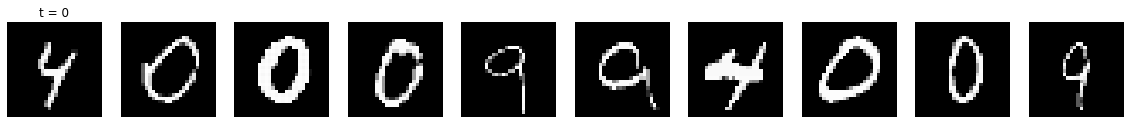

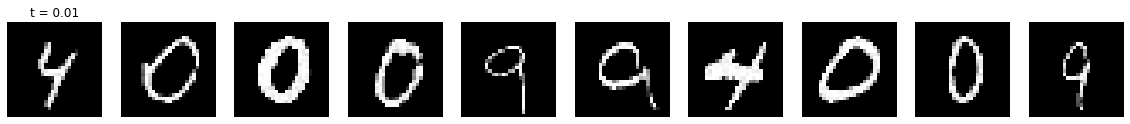

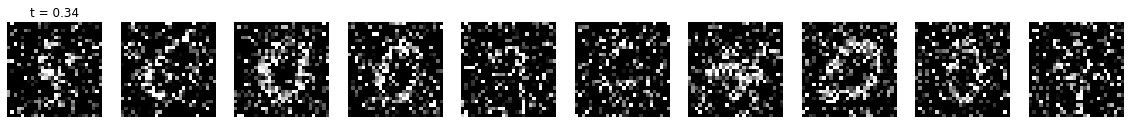

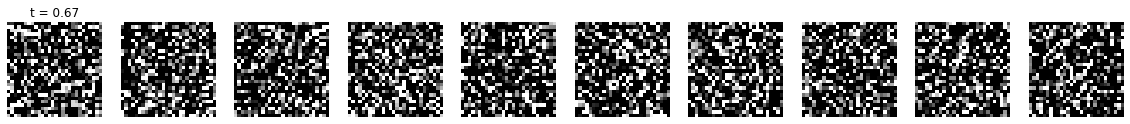

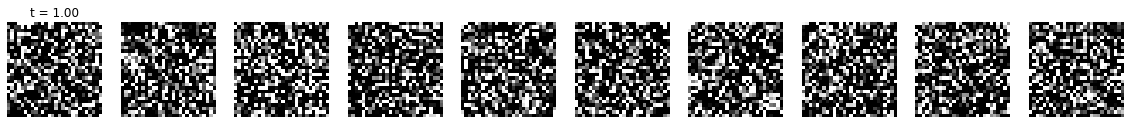

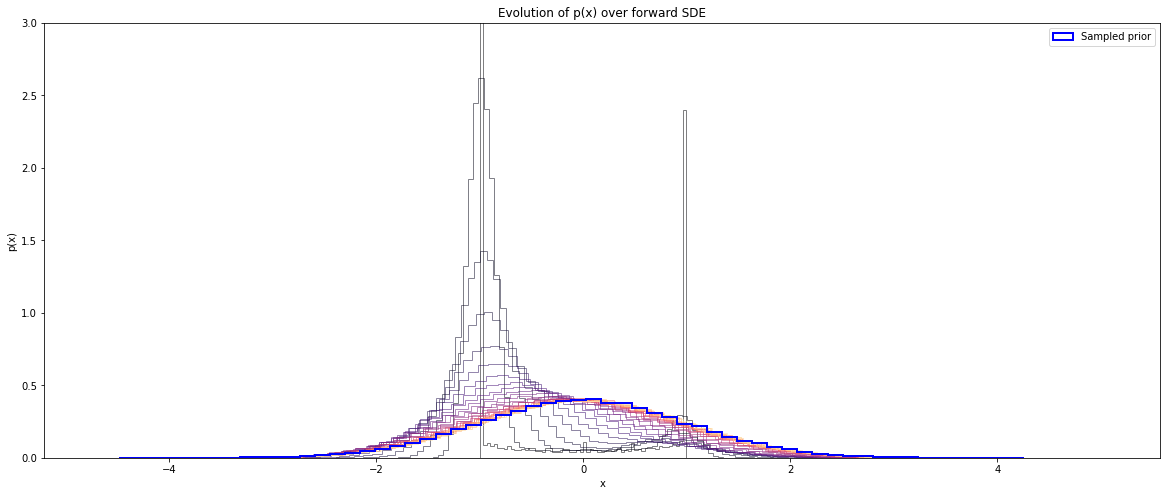

In [10]:
# Show some images after running the SDE forward for different times
time_steps = 4

x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()

plot_digits(np.clip(x0, 0, 1), title="t = 0")
x0 = torch.tensor(x0).to(DEVICE)
for t in np.linspace(0.01, t_limit, time_steps):
    xt, score = sde.forward(x0, torch.full(x0.shape[:1], t).to(DEVICE))
    plot_digits(torch.clamp(xt, 0, 1).cpu().numpy(), title=("t = %.2f" % t))
    
# Show the transformation of the distribution of data to the prior distribution
time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

In [11]:
saved_vals = []
train_model(
    model, sde, data_loader, num_epochs=30, learning_rate=0.001,
    loss_weighting_type="empirical_norm", t_limit=t_limit
)

  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1 average Loss: 321.97


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2 average Loss: 117.88


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3 average Loss: 86.25


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 4 average Loss: 80.88


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 5 average Loss: 70.24


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 6 average Loss: 66.06


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 7 average Loss: 58.20


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 8 average Loss: 56.35


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 9 average Loss: 52.96


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 10 average Loss: 53.27


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 11 average Loss: 50.64


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 12 average Loss: 46.64


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 13 average Loss: 47.42


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 14 average Loss: 46.37


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 15 average Loss: 43.79


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 16 average Loss: 44.30


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 17 average Loss: 41.91


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 18 average Loss: 42.54


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 19 average Loss: 42.20


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 20 average Loss: 40.18


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 21 average Loss: 39.47


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 22 average Loss: 39.29


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 23 average Loss: 38.48


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 24 average Loss: 38.28


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 25 average Loss: 37.47


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 26 average Loss: 37.74


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 27 average Loss: 37.58


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 28 average Loss: 36.69


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 29 average Loss: 36.70


  0%|          | 0/139 [00:00<?, ?it/s]

Epoch 30 average Loss: 36.83


### Sample from the trained model

The three strategies for sampling from the trained model are:

1. Euler-Maruyama: We take the corresponding reverse SDE and step through it backwards through time
2. Predictor-Corrector: Like Euler-Maruyama, but in each step we also run a round of Langevin dynamics to better align the step with the score function
3. ODE: We take the corresponding ODE of the reverse SDE (which has the same transitional probabilities) and step through it backwards through time using an ODE solver

In [12]:
def generate_samples(
    model, sde, class_to_sample, sampler="em", num_samples=64, num_steps=500, t_start=0.001,
    t_limit=1, xt=None, verbose=True
):
    """
    Generates samples from a trained score model and SDE. This first
    generates a sample from the SDE's prior distribution a t = 1, then
    steps backward through time to generate new data points.
    Arguments:
        `model`: a trained score model which takes in x, t and
            predicts score
        `sde`: an SDE object
        `class_to_sample`: the class to sample from
        `sampler`: one of "em", "pc", or "ode" for Euler-Maruyama,
            predictor-corrector, or ordinary differential equation,
            respectively
        `num_samples`: number of objects to return
        `num_steps`: number of steps to take for Euler-Maruyama and
            predictor-corrector algorithms
        `t_start`: last time step to stop at before hitting 0
        `t_limit`: the time step to start generating at
        `xt`: if given, this is a `num_samples` x ... tensor to start
            generating at (at time `t_limit`) instead of sampling from
            the prior
        `verbose`: whether or not to show progress and other messages
    Returns a tensor of size `num_samples` x ...
    """
    t = torch.tensor(np.tile(t_limit, num_samples)).to(DEVICE)
    if xt is not None:
        assert xt.shape[0] == num_samples
    else:
        # Sample from the prior distribution at some late time t
        xt = sde.sample_prior(num_samples, t)
    
    # Disable gradient computation in model
    torch.set_grad_enabled(False)
    
    if sampler == "em":
        # Euler-Maruyama
        time_steps = torch.linspace(t_limit, t_start, num_steps).to(DEVICE)  # Descending order
        step_size = time_steps[0] - time_steps[1]
        
        # Step backward through time starting at xt, simulating the reverse SDE
        x = xt
        t_iter = tqdm.notebook.tqdm(time_steps) if verbose else time_steps
        for time_step in t_iter:
            branch_index = class_time_to_branch(class_to_sample, time_step, branch_defs)
            t = torch.ones(num_samples).to(DEVICE) * time_step
            f = sde.drift_coef_func(x, t)
            g = sde.diff_coef_func(x, t)
            dw = torch.randn_like(x)
            
            drift = (f - (torch.square(g) * model(x, t)[:, branch_index])) * step_size
            diff = g * torch.sqrt(step_size) * dw
            
            mean_x = x - drift  # Subtract here because step size is really negative
            x = mean_x + diff
        return mean_x  # In the last step, don't include the diffusion/randomized term
    
    elif sampler == "pc":
        # Predictor-Corrector
        time_steps = torch.linspace(t_limit, t_start, num_steps).to(DEVICE)  # Descending order
        step_size = time_steps[0] - time_steps[1]
        
        # Step backward through time starting at xt
        x = xt
        t_iter = tqdm.notebook.tqdm(time_steps) if verbose else time_steps
        for time_step in t_iter:
            branch_index = class_time_to_branch(class_to_sample, time_step, branch_defs)
            t = torch.ones(num_samples).to(DEVICE) * time_step
            
            # Take Langevin MCMC step
            score = model(x, t)[:, branch_index]
            
            snr = 0.1
            score_norm = torch.mean(torch.norm(score.reshape(score.shape[0], -1), dim=-1))
            alpha = snr * (torch.prod(torch.tensor(x.shape[1:])) / torch.square(score_norm))
            
            x = x + ((alpha / 2) * score) + (torch.sqrt(alpha) * torch.randn_like(x))
            
            # Take SDE step
            f = sde.drift_coef_func(x, t)
            g = sde.diff_coef_func(x, t)
            dw = torch.randn_like(x)
            
            drift = (f - (torch.square(g) * model(x, t)[:, branch_index])) * step_size
            diff = g * torch.sqrt(step_size) * dw
            
            mean_x = x - drift  # Subtract here because step size is really negative
            x = mean_x + diff
            
        return mean_x  # In the last step, don't include the diffusion/randomized term
    
    elif sampler == "ode":
        # ODE
        x_shape = tuple(torch.tensor(xt.shape).numpy())
        
        # Define function used by ODE solver:
        def ode_func(t, x):
            # t is a scalar; x is a 1D NumPy array
            branch_index = class_time_to_branch(class_to_sample, t, branch_defs)
            x_tens = torch.tensor(x).float().to(DEVICE).view(x_shape)
            t_tens = torch.ones(num_samples).to(DEVICE) * t
            
            score_tens = model(x_tens, t_tens)[:, branch_index]
            f_tens = sde.drift_coef_func(x_tens, t_tens)
            g_tens = sde.diff_coef_func(x_tens, t_tens)
            
            step_tens = f_tens - (0.5 * torch.square(g_tens) * score_tens)
            return step_tens.reshape(-1).cpu().numpy().astype(np.float64)
        
        # Run the ODE solver
        result = scipy.integrate.solve_ivp(
            ode_func, (t_limit, t_start),
            xt.reshape(-1).cpu().numpy(),
            rtol=0.00001, atol=0.00001,
            method="RK45"
        )
        if verbose:
            print("Number of ODE function evaluations: %d" % result.nfev)
        return torch.tensor(result.y[:, -1]).to(DEVICE).reshape(x_shape)

In [13]:
weights = torch.load("ckpt.pth")
model.load_state_dict(weights)

<All keys matched successfully>

Sampling class: 0


  0%|          | 0/500 [00:00<?, ?it/s]

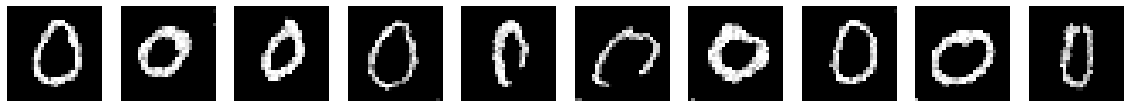

Sampling class: 4


  0%|          | 0/500 [00:00<?, ?it/s]

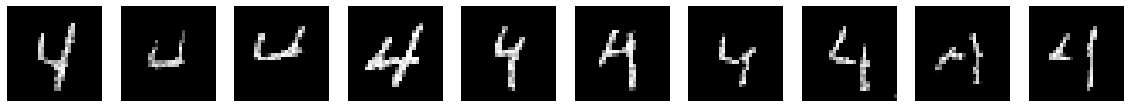

Sampling class: 9


  0%|          | 0/500 [00:00<?, ?it/s]

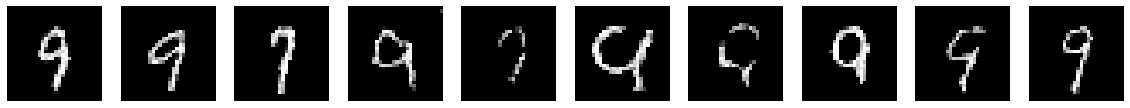

In [14]:
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    samples = generate_samples(model, sde, class_to_sample, sampler="pc", t_limit=t_limit)
    plot_digits(torch.clamp(samples, 0, 1).cpu(), title=None)

**Intermediate states**

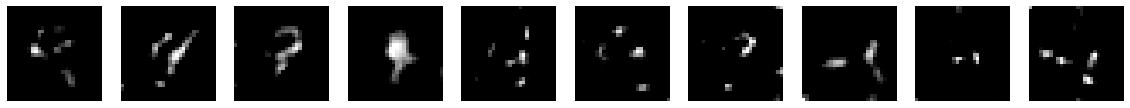

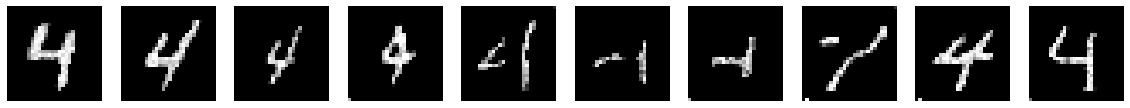

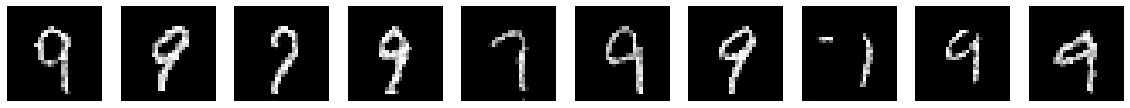

In [15]:
samples_49 = generate_samples(model, sde, 4, sampler="pc", t_start=0.3, t_limit=t_limit, verbose=False).cpu().numpy()
samples_4 = generate_samples(model, sde, 4, sampler="pc", t_limit=0.3, xt=torch.tensor(samples_49).to(DEVICE), verbose=False).cpu().numpy()
samples_9 = generate_samples(model, sde, 9, sampler="pc", t_limit=0.3, xt=torch.tensor(samples_49).to(DEVICE), verbose=False).cpu().numpy()

smoothed_samples_49 = np.empty_like(samples_49)
for i in range(len(samples_49)):
    smoothed_samples_49[i, 0] = scipy.ndimage.gaussian_filter(samples_49[i, 0], sigma=1)
plot_digits(np.clip(smoothed_samples_49, 0, 1))
plot_digits(np.clip(samples_4, 0, 1))
plot_digits(np.clip(samples_9, 0, 1))

**Diffusing from one class to another**

/local/52897373/ipykernel_19905/2438839086.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  orig_4_tens, orig_9_tens = torch.tensor(orig_4).to(DEVICE), torch.tensor(orig_9).to(DEVICE)


4 to 9


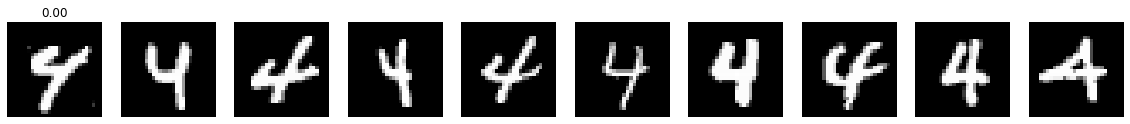

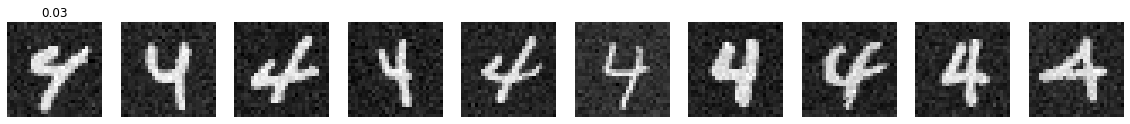

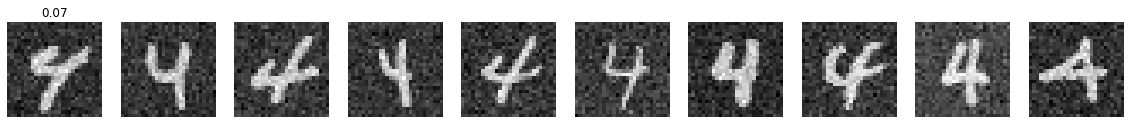

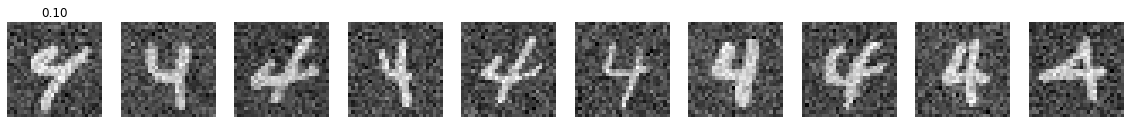

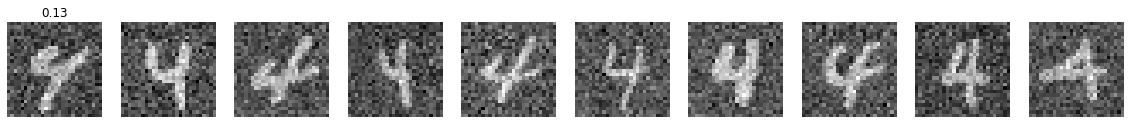

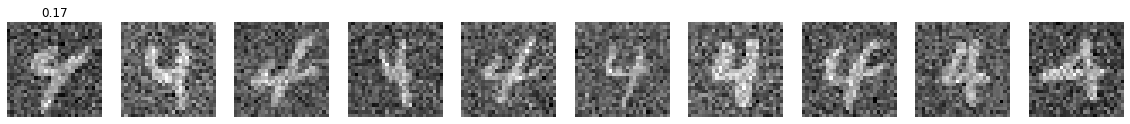

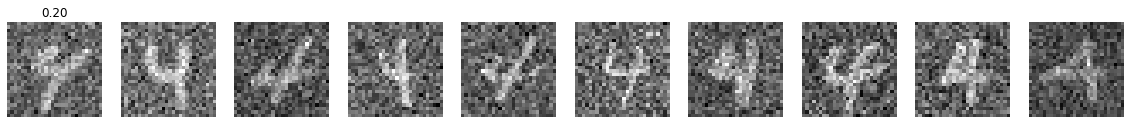

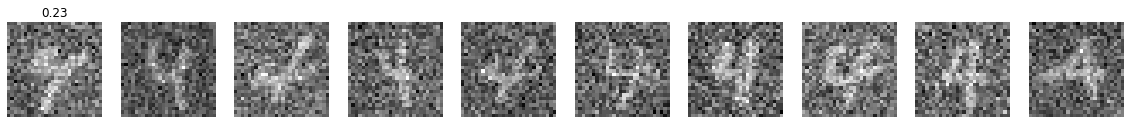

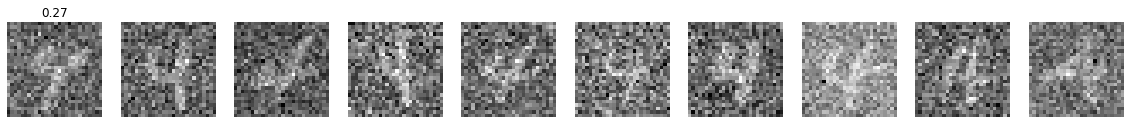

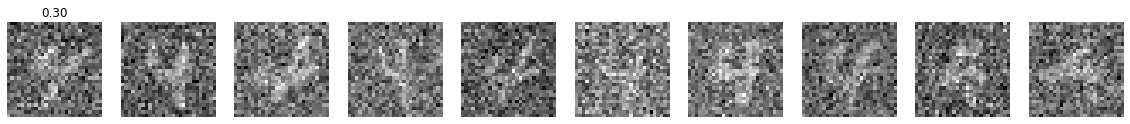

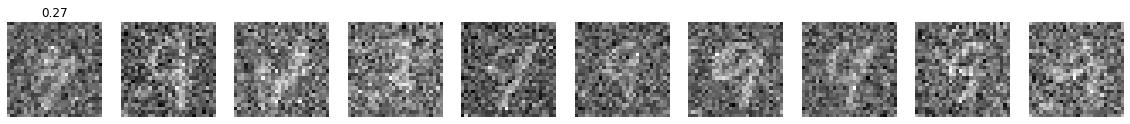

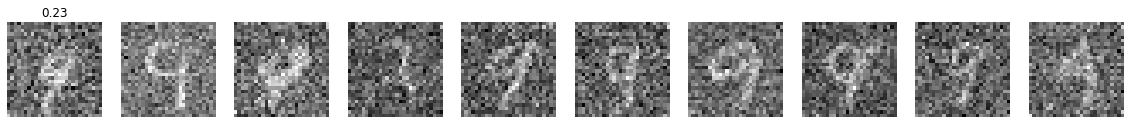

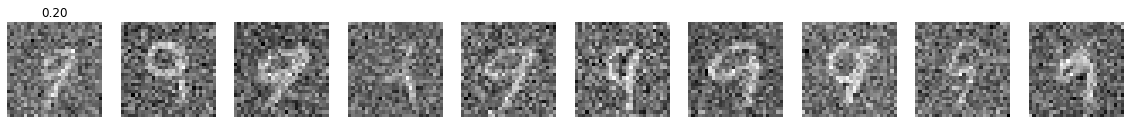

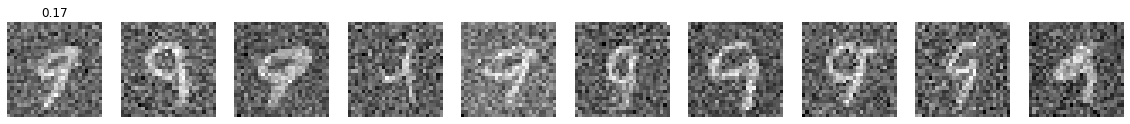

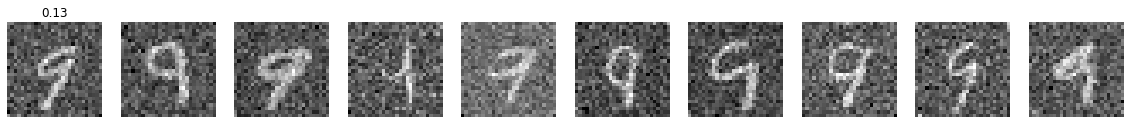

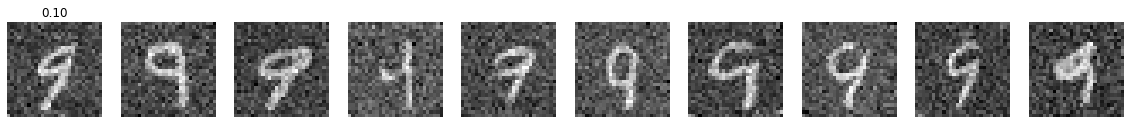

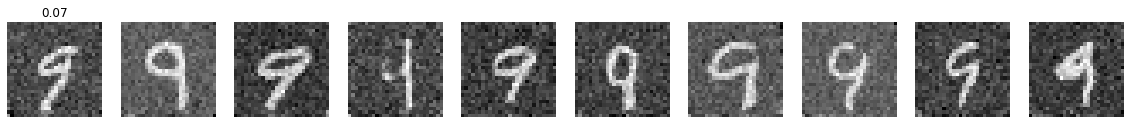

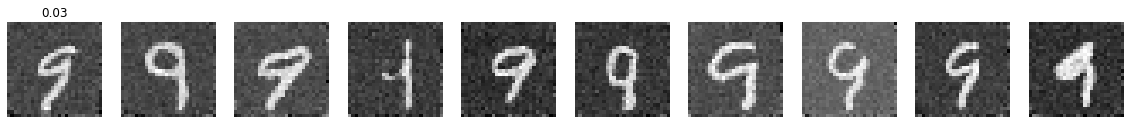

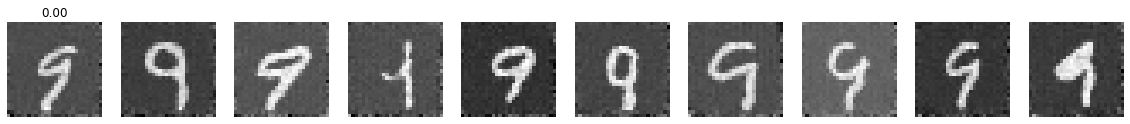

9 to 4


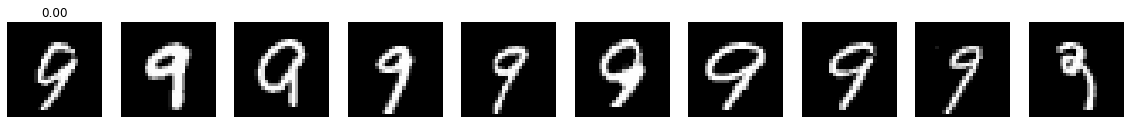

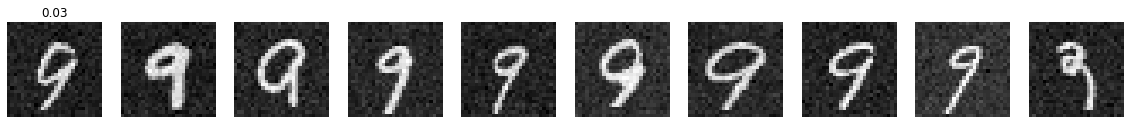

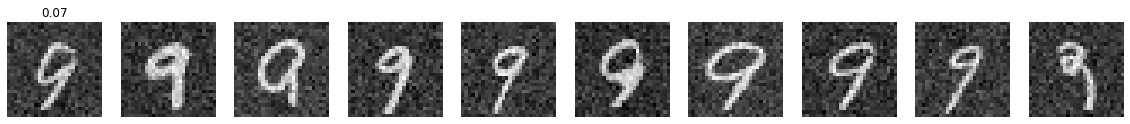

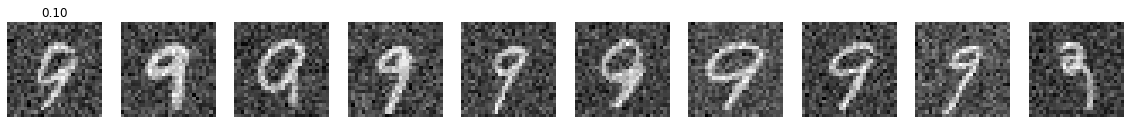

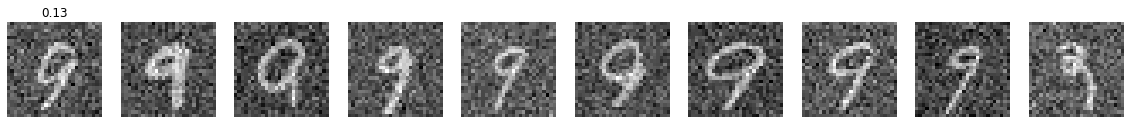

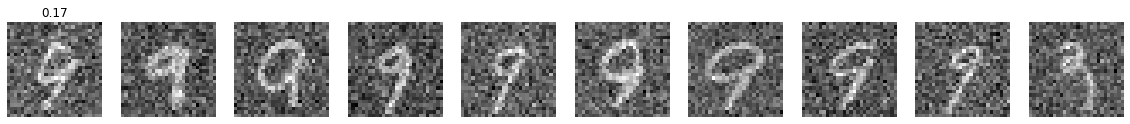

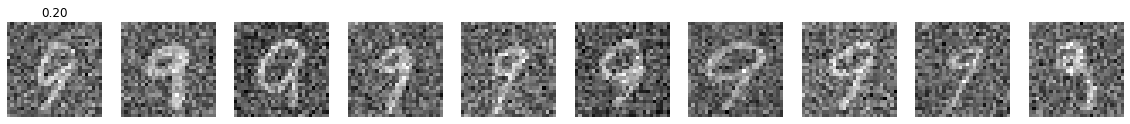

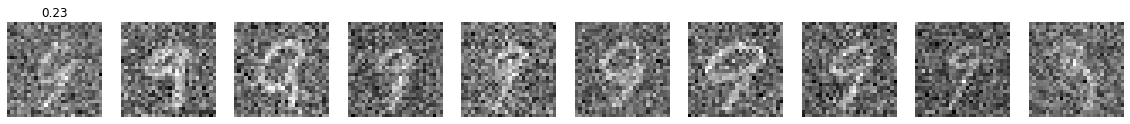

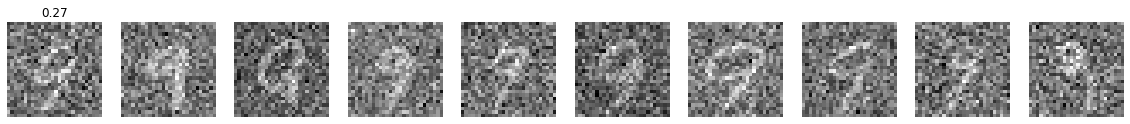

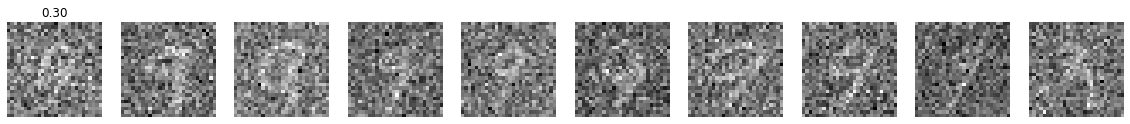

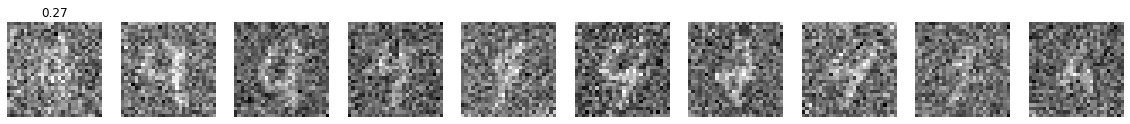

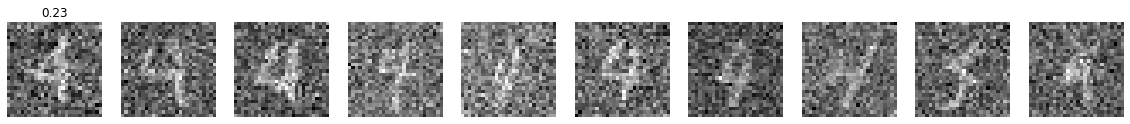

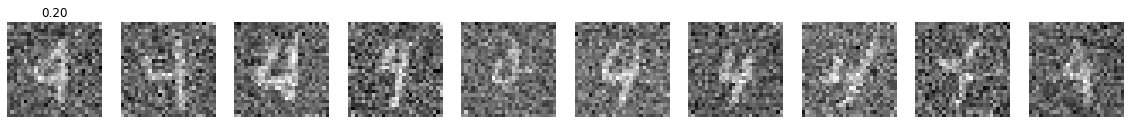

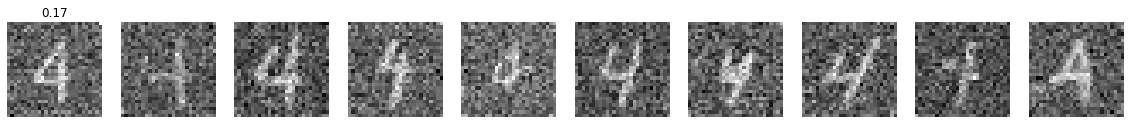

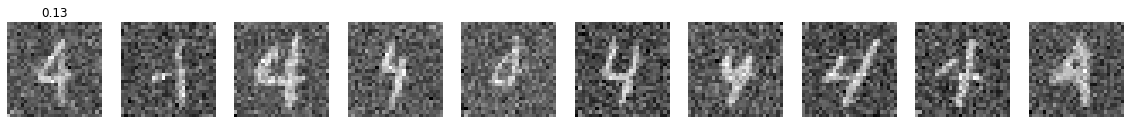

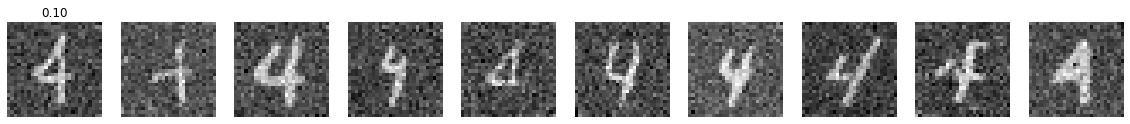

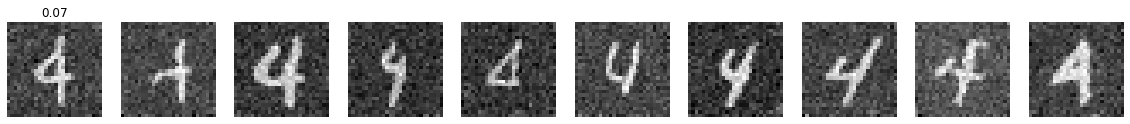

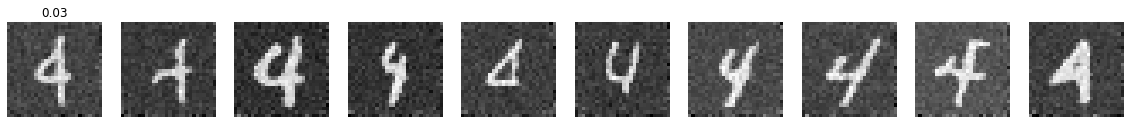

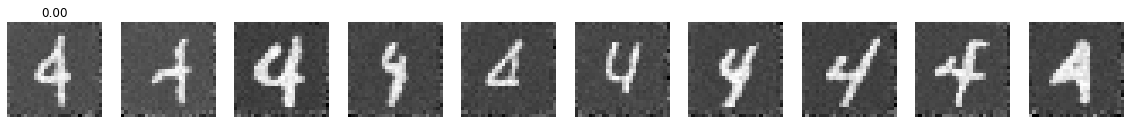

In [16]:
orig_4 = torch.stack([
    torch.tensor(dataset[i][0], device=DEVICE) for i in 
    np.random.choice(np.where(dataset.targets == 4)[0], size=32, replace=False)
])
orig_9 = torch.stack([
    torch.tensor(dataset[i][0], device=DEVICE) for i in 
    np.random.choice(np.where(dataset.targets == 9)[0], size=32, replace=False)
])

time_steps = 10
all_t = np.linspace(0, 0.3, time_steps)
forward_4_to_9 = np.empty((len(all_t),) + orig_4.shape)
backward_4_to_9 = np.empty((len(all_t) - 1,) + orig_4.shape)
forward_9_to_4 = np.empty((len(all_t),) + orig_4.shape)
backward_9_to_4 = np.empty((len(all_t) - 1,) + orig_4.shape)
orig_4_tens, orig_9_tens = torch.tensor(orig_4).to(DEVICE), torch.tensor(orig_9).to(DEVICE)
for t_i, t in enumerate(all_t):
    forward_4_to_9[t_i] = sde.forward(
        orig_4_tens, torch.ones(len(orig_4_tens)).to(DEVICE) * t
    )[0].cpu().numpy()
    forward_9_to_4[t_i] = sde.forward(
        orig_9_tens, torch.ones(len(orig_9_tens)).to(DEVICE) * t
    )[0].cpu().numpy()

all_t_flip = np.flip(all_t)
last_4_to_9 = torch.tensor(forward_4_to_9[-1]).to(DEVICE).float()
last_9_to_4 = torch.tensor(forward_9_to_4[-1]).to(DEVICE).float()
for t_i in range(len(all_t_flip) - 1):
    last_4_to_9 = generate_samples(
        model, sde, 9, sampler="pc", t_limit=all_t_flip[t_i],
        t_start=all_t_flip[t_i + 1], num_samples=orig_4.shape[0],
        xt=last_4_to_9, num_steps=50, verbose=False
    )
    backward_4_to_9[t_i] = last_4_to_9.cpu().numpy()
    
    last_9_to_4 = generate_samples(
        model, sde, 4, sampler="pc", t_limit=all_t_flip[t_i],
        t_start=all_t_flip[t_i + 1], num_samples=orig_9.shape[0],
        xt=last_9_to_4, num_steps=50, verbose=False
    )
    backward_9_to_4[t_i] = last_9_to_4.cpu().numpy()
    
print("4 to 9")
for t_i, t in enumerate(all_t):
    plot_digits(forward_4_to_9[t_i], title=("%.2f" % t))
for t_i, t in enumerate(all_t_flip[1:]):
    plot_digits(backward_4_to_9[t_i], title=("%.2f" % t))

print("9 to 4")
for t_i, t in enumerate(all_t):
    plot_digits(forward_9_to_4[t_i], title=("%.2f" % t))
for t_i, t in enumerate(all_t_flip[1:]):
    plot_digits(backward_9_to_4[t_i], title=("%.2f" % t))